# Running an example simulation
It's all very simple, mostly because this is a simple simulation. 
First, let's import stuff we'll need later on:

In [1]:
import numpy as np

from pandemic_sim.simulation import Person, Room, Simulation
from pandemic_sim.visualizations import DefaultVisualization
from pandemic_sim.animators import CelluloidAnimator

- `Person` is class representing a person with attributes such as position in the room, infection status and whether the person is dead or alive
- `Room` represents a room and is probably totally useless. Its only attributes are the width and the height of thre room
- `Simulation` is the class containing the actual simulation code
- in `DefaultVisualization` is the... well... default visualization. It shows all persons as solid circles and additionally plots the timeline of infected and immune persons and fatalities
- `CelluloidAnimator` contains code to animate a visualization using the [`celluloid` package](https://github.com/jwkvam/celluloid)

If you want to change any of these components, the object-oriented design should make it relatively easy to, e.g., implement a new visualization. The visualization and animation code is currently not documented, though.

Preamble done, so let's start setting up our simulation:

In [2]:
n_persons = 500
room = Room(40, 40)
# persons start with random positions and velocities
persons = [Person(pos=np.random.uniform(low=(0,0), 
                                        high=(room.w, room.h)),
                  vel=np.random.uniform(low=(-2, -2), 
                                        high=(2, 2)),
                  in_prob=0.2, out_prob=0.2, death_prob=0.0002, 
                  infected=False, immune=False)
           for _ in range(n_persons)]

So we're going to have 500 persons moving around in a room with width 80 and height 80 (arbitrary units). The interesting parameters of a `Person` are the probabilities to get infected (`in_prob`) to spread the infection (`out_prob`) in an encounter with another person. `death_prob` is the probability for an infected person to die in one unit of simulation time.  
Now we want some random persons to start out infected:

In [3]:
chosen_ones = np.random.choice(np.arange(n_persons), n_persons // 50)
for i in chosen_ones:
    persons[i].infected = True

Sorry, guys.  
On to setting up the simulation object:

In [4]:
sim = Simulation(room, persons, prob_dist=lambda d:  d < 1, dt=0.1,
                 cutoff=1, transmit_cutoff=2, force_constant=20,
                 time_to_heal=140)

Lots of parameters here:
- `prob_dist`: a distance-dependent "base probability" for transmission. Here set to constant; if two persons are separated by more than one distance unit, no transmission will occur
- `dt`: the time step for the integration scheme, which approximately solves the equations of motions for persons. The smaller that parameter is, the more accurate and detailed the simulated movement, but the longer the simulation takes to cover some predefined time span
- `cutoff`: distance at which the repulsive force between two persons (which makes them bounce off each other) kicks in
- `transmit_cutoff`: distance above which the probability of transmitting the infection between two persons if zero
- `force_constant`: determines how hard two people bounce off each other. If this were set to zero, they could just pass through each other
- `time_to_heal`: number of simulation time units it takes for an infected person to get cured (and thus become immune)

Now we can run the simulation for some number `n_steps`. Get some coffee!

In [5]:
n_steps = 600
simulation_results = sim.run(n_steps)

Simulating step 0/600...
Simulating step 50/600...
Simulating step 100/600...
Simulating step 150/600...
Simulating step 200/600...
Simulating step 250/600...
Simulating step 300/600...
Simulating step 350/600...
Simulating step 400/600...
Simulating step 450/600...
Simulating step 500/600...
Simulating step 550/600...
Done.


Done? Amazing. Let's use the above-discussed `DefaultVisualization` and the `CelluloidAnimator` to get a `.mp4` file with the animated simulation results:

Animating step 0/600...
Animating step 50/600...
Animating step 100/600...
Animating step 150/600...
Animating step 200/600...
Animating step 250/600...
Animating step 300/600...
Animating step 350/600...
Animating step 400/600...
Animating step 450/600...
Animating step 500/600...
Animating step 550/600...
Done.


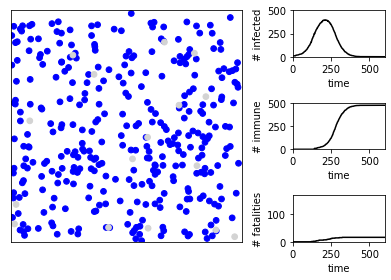

In [6]:
viz = DefaultVisualization(simulation_results, room, radius=sim.cutoff / 2)
animator = CelluloidAnimator(viz, out="output.mp4")
animator.animate(n_steps)

The `radius` argument determines the radius of the circles representing the persons. You want to set this to `sim.cutoff / 2`, otherwise things will look weird.  
Animating takes quite a while, too; comparable to the time it takes to run the simulation itself.  
Let's view the results:

In [7]:
from IPython.display import Video
Video("output.mp4")

That's it&mdash;enjoy playing around with the parameters and the code and if you have suggestions on how to improve all this, feel free to open an issue and / or a pull request!